In [1]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client

c = Client()
c

Client Scheduler: tcp://127.0.0.1:42064 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 12.88 GB


In [2]:
## path for mdules

import sys
sys.path.insert(0,"/gpfswork/rech/egi/rote001/git/xscale")
import xscale

sys.path.insert(0,"/gpfswork/rech/egi/rote001/git/diags-CMEMS-on-occigen/common-lib/")
import GriddedData

## imports

import numpy as np
import numpy.ma as ma
import xarray as xr
import time

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.cm as mplcm
seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import matplotlib.pyplot as plt

import glob
import os 

%matplotlib inline

In [3]:
gridfile='/gpfsstore/rech/egi/commun/MEDWEST60/MEDWEST60-I/MEDWEST60_mesh_hgr.nc4'
maskfile='/gpfsstore/rech/egi/commun/MEDWEST60/MEDWEST60-I/MEDWEST60_mask.nc4'

In [4]:
grid=xr.open_dataset(gridfile)
navlat= grid['nav_lat']
navlon= grid['nav_lon']

e1u=grid.e1u
e1v=grid.e1v
e2u=grid.e2u
e2v=grid.e2v
ff=grid.ff


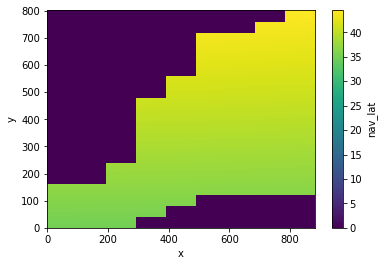

In [35]:
dsm=xr.open_dataset(maskfile)
dsm.nav_lat.plot()

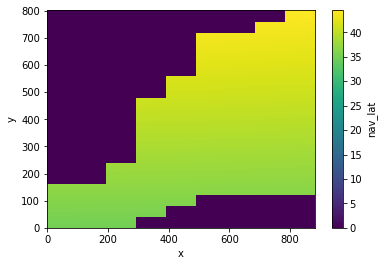

In [34]:
navlat.plot()

In [5]:
def filt(w):
    win_box2D = w.window
    win_box2D.set(window='hanning', cutoff=54, dim=['x', 'y'], n=[54, 54])
    bw = win_box2D.boundary_weights(drop_dims=[])
    w_LS = win_box2D.convolve(weights=bw)
    w_SS=w-w_LS
    return w_SS


In [6]:
def curl(u,v,e1v,e2u,ff):
    '''
    This routine computes the relative vorticity from 2D fields of horizontal velocities and the spatial Coriolis parameter.
    '''
    #Computation of dy(u)
    fe2u=1/e2u
    fse2u=fe2u.squeeze()
    dyu=(u.shift(y=-1) - u)*fse2u
    #Computation of dx(v)
    fe1v=1/e1v
    fse1v=fe1v.squeeze()
    dxv=(v.shift(x=-1) - v)*fse1v
    #Projection on the grid T
    dxvt=0.5*(dxv.shift(y=-1)+dxv)
    dyut=0.5*(dyu.shift(x=-1)+dyu)
    #Computation of the vorticity divided by f
    fff=1/ff
    curl=(dxvt-dyut)*fff
    return curl

In [7]:
datadir='/gpfsstore/rech/egi/commun/MEDWEST60/MEDWEST60-GSL12-S/ens01/1h/'
filesU=datadir+'gridU-2D/002MEDWEST60-GSL12-ens01_1h_*_gridU-2D_2010021*-2010021*.nc'
filesV=datadir+'gridV-2D/002MEDWEST60-GSL12-ens01_1h_*_gridV-2D_2010021*-2010021*.nc'

dsU=xr.open_mfdataset(filesU,combine='by_coords',chunks={'x':800,'y':800,'time_counter':1})
dsV=xr.open_mfdataset(filesV,combine='by_coords',chunks={'x':800,'y':800,'time_counter':1})

uMED=dsU.sozocrtx
vMED=dsV.somecrty

In [8]:
curlMED   = curl(uMED,vMED,e1v,e2u,ff)

In [9]:
curlMED_sq=curlMED.squeeze()
curlMED_rechunk=curlMED_sq.chunk(chunks={'time_counter':1,'x':883,'y':803})

In [10]:
curlMED_filt=filt(curlMED_rechunk)

In [11]:
    curlMED_LS=curlMED_sq-curlMED_filt
    hpcurlMED=curlMED_filt
    hpcurlMED2 = hpcurlMED ** 2
    hpcurlMED2m = hpcurlMED2.mean(axis=0,keep_attrs=True)
    navlat2=np.array(navlat).squeeze()
    navlon2=np.array(navlon).squeeze()
    mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
    crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
    hpcurlMED2mc = crs.return_ravel(np.asarray(hpcurlMED2m))
    hpcurlMED2mcm = np.mean(hpcurlMED2mc,axis=-3)
    latcrs=crs.return_ravel(np.asarray(navlat2))
    loncrs=crs.return_ravel(np.asarray(navlon2))
    latcrsm=np.mean(latcrs,axis=-3)
    loncrsm=np.mean(loncrs,axis=-3)


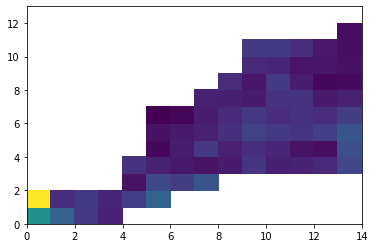

In [27]:
plt.pcolormesh(hpcurlMED2mcm)

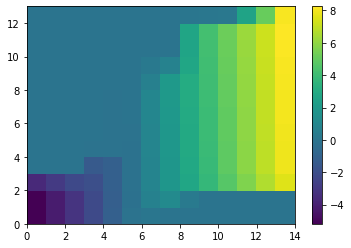

In [29]:
plt.pcolormesh(loncrsm)
plt.colorbar()

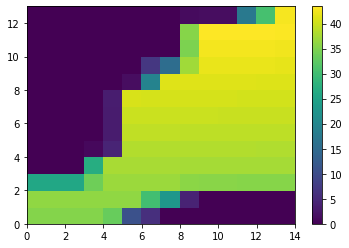

In [30]:
plt.pcolormesh(latcrsm)
plt.colorbar()

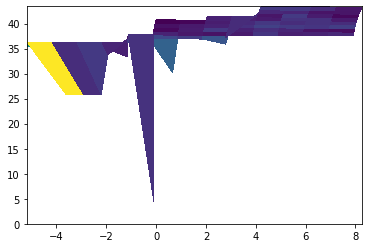

In [32]:
plt.pcolormesh(loncrsm,latcrsm,hpcurlMED2mcm)

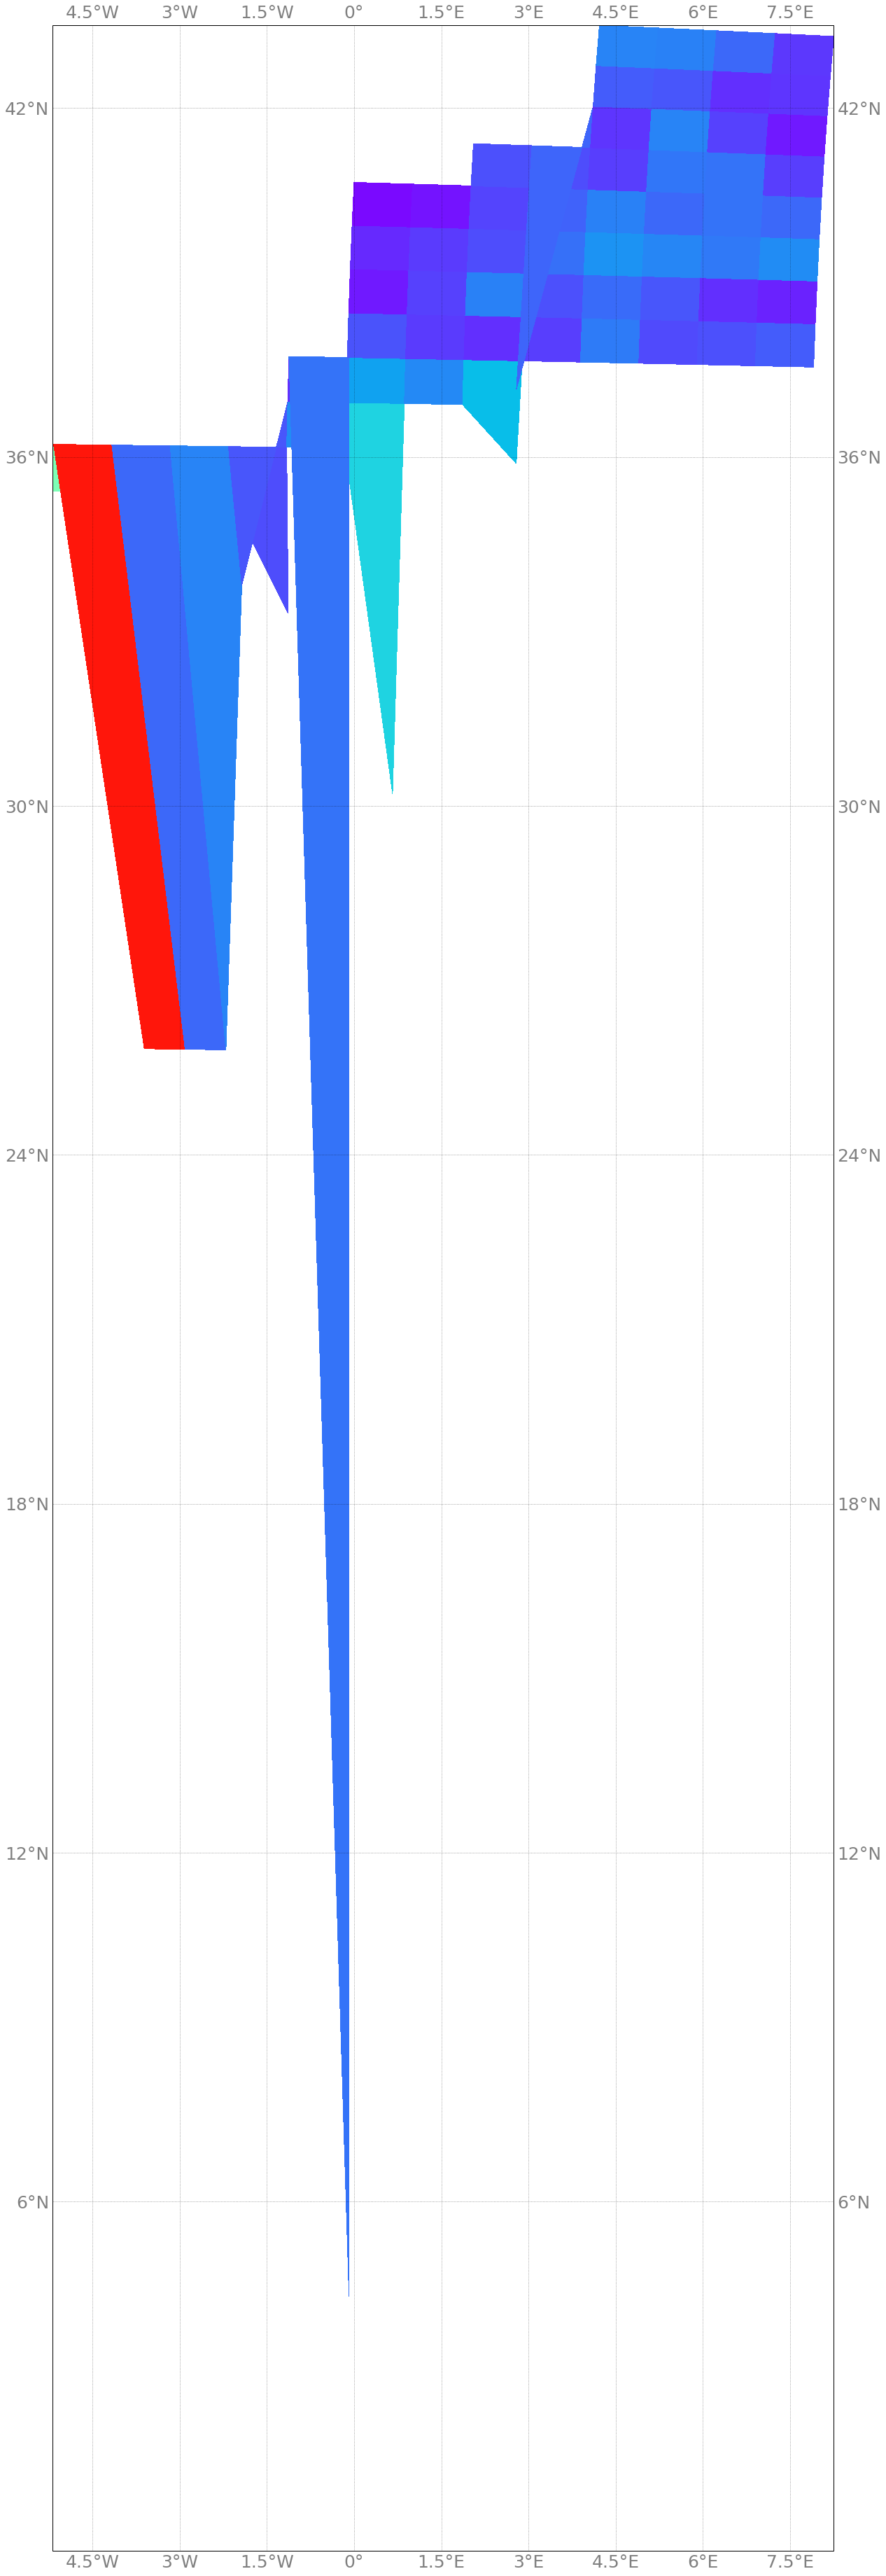

In [24]:
fig, ax = plt.subplots(1,1,figsize=(20,300))
ax = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=0))
ax.autoscale(tight=True)
cont=np.isnan(hpcurlMED2m)
gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 25, 'color': 'gray'}
gl.ylabel_style = {'size': 25, 'color': 'gray'}
    
ax.tick_params('both',labelsize=25)

pcolor = ax.pcolormesh(loncrsm,latcrsm,ma.masked_invalid(hpcurlMED2mcm),cmap=mplcm.rainbow,vmin=0,vmax=1,alpha=1)
#ax.contour(navlon,navlat,cont,alpha=0.5,linewidth=0.000001,antialiased=True,colors='black')
#cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
#cbar.ax.tick_params(labelsize=35)
#cbar.ax.tick_params(labelsize=25)
#cbar.set_label('Small scales surface buoyancy horizontal gradient in february 2010 for MEDWEST60-GSL12 001',fontsize=15)
plt.savefig('Plots/001MEDWEST60-GSL12_y2010m02_fine_scale_horizontal_gradient_buoyancy.png')